In [1]:
#to install R :
#conda install -c r r-irkernel
# to install a library from R
#!pip install library edgeR

In [2]:
#we just do it once
#!pip3 install xgboost

In [3]:
# a pachage that might need for some normalisation later on.
#!pip install rnanorm;
#import rnanorm

In [4]:
#this package has many of the normalisation procedures.
#!pip install bioinfokit
#!pip install bioinfokit --upgrade 

In [5]:
#!pip install conorm
from bioinfokit.analys import norm, get_data
import bioinfokit
import conorm # for tmm normalisation

In [6]:
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from pathlib import Path
import functools
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
#loading the count data

path1=Path("/home/znazari/machine_learning_ppmi")

quant_rna1=pd.read_csv(path1/"ordered_bl_matrix_ir2_count.txt", header=None,index_col=[0] )
quant_rna=quant_rna1.rename(columns=quant_rna1.iloc[0]).drop(quant_rna1.index[0]).reset_index(drop=True)

In [8]:
#loading the data

path2=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Study_Docs")

data_std=pd.read_csv(path2/"Data_Dictionary_-_Harmonized.csv", header=None,index_col=[0] )
std_data=data_std.rename(columns=data_std.iloc[0]).drop(data_std.index[0]).reset_index(drop=True)

In [9]:
std_data.set_index('ITM_NAME', inplace=True)

In [10]:
std_data.loc['ENRLLRRK2']


,PAG_NAME,DSCR,ITM_TYPE,FLD_LEN,DECML,ITM_REQUIRED,ITM_UNIQUE
ITM_NAME,,,,,,,
ENRLLRRK2,NaN,LRRK2 Mutation at Enrollment,NUMBER,1,NaN,True,False
ENRLLRRK2,NaN,LRRK2 Mutation at Participant Creation,NUMBER,1,NaN,True,False


In [11]:
#loading the counts data

path_=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Subject_Characteristics")

data_ps=pd.read_csv(path_/"Participant_Status.csv", header=None )
ps_data=data_ps.rename(columns=data_ps.iloc[0]).drop(data_ps.index[0]).reset_index(drop=True)
ps_data

,PATNO,COHORT,COHORT_DEFINITION,ENROLL_DATE,ENROLL_STATUS,STATUS_DATE,ENROLL_AGE,INEXPAGE,AV133STDY,PPMI_ONLINE_ENROLL,...,COMMENTS,CONDATE,ENRLPINK1,ENRLPRKN,ENRLSRDC,ENRLHPSM,ENRLRBD,ENRLLRRK2,ENRLSNCA,ENRLGBA
0,3000,2,Healthy Control,02/2011,enrolled,05/2021,69.1,INEXHC,0,NO,...,NaN,06/2021,0,0,0,0,0,0,0,0
1,3001,1,Parkinson's Disease,03/2011,enrolled,09/2021,65.1,INEXPD,0,NO,...,NaN,06/2021,0,0,1,0,0,0,0,0
2,3002,1,Parkinson's Disease,03/2011,enrolled,09/2021,67.6,INEXPD,0,NO,...,NaN,06/2021,0,0,1,0,0,0,0,0
3,3003,1,Parkinson's Disease,04/2011,enrolled,01/2022,56.7,INEXPD,0,NO,...,NaN,06/2021,0,0,1,0,0,0,0,0
4,3004,2,Healthy Control,04/2011,enrolled,01/2022,59.4,INEXHC,0,YES,...,NaN,06/2021,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,162994,1,Parkinson's Disease,NaN,screened,07/2022,NaN,INEXPD,0,NO,...,NaN,NaN,0,0,1,0,0,0,0,0
2347,163265,1,Parkinson's Disease,NaN,screened,07/2022,NaN,INEXPD,0,YES,...,NaN,NaN,0,0,1,0,0,0,0,0
2348,164900,1,Parkinson's Disease,NaN,screened,07/2022,NaN,INEXPD,0,NO,...,NaN,NaN,0,0,1,0,0,0,0,0
2349,167222,1,Parkinson's Disease,NaN,screened,08/2022,NaN,INEXPD,0,NO,...,NaN,NaN,0,0,1,0,0,0,0,0


In [12]:
ln_data=ps_data[["PATNO","ENRLGBA", "ENRLLRRK2", "ENRLSNCA"]]
ln_data

,PATNO,ENRLGBA,ENRLLRRK2,ENRLSNCA
0,3000,0,0,0
1,3001,0,0,0
2,3002,0,0,0
3,3003,0,0,0
4,3004,0,0,0
...,...,...,...,...
2346,162994,0,0,0
2347,163265,0,0,0
2348,164900,0,0,0
2349,167222,0,0,0


In [13]:
ln_data.iloc[992]

PATNO        40730
ENRLGBA          0
ENRLLRRK2        0
ENRLSNCA         1
Name: 992, dtype: object

In [14]:
rut_=ln_data["PATNO"]

In [15]:
#this is to select the indices of the patients that have these diseases: SNCA, GBA, LRRK2
count_SNCA = (ln_data['ENRLSNCA'] != "0")
el_SNCA=count_SNCA[count_SNCA].index.values
el_SNCA
count_GBA = (ln_data['ENRLGBA'] != "0")
el_GBA=count_GBA[count_GBA].index.values
el_GBA
count_LRRK2 = (ln_data['ENRLLRRK2'] != "0")
el_LRRK2=count_LRRK2[count_LRRK2].index.values
el_LRRK2

array([ 917,  918,  920,  921,  922,  923,  934,  935,  936,  937,  938,
        939,  940,  941,  942,  943,  944,  945,  946,  947,  948,  949,
        950,  951,  952,  953,  954,  955,  956,  957,  958,  959,  960,
        961,  962,  963,  964,  965,  966,  967,  968,  969,  970,  971,
        972,  973,  974,  975,  976,  977,  978,  979,  980,  981,  982,
        983,  984,  985,  986,  987,  988,  989,  990,  991,  994, 1021,
       1022, 1023, 1024, 1025, 1027, 1028, 1029, 1030, 1031, 1033, 1035,
       1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046,
       1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1058,
       1059, 1060, 1061, 1062, 1063, 1067, 1069, 1070, 1071, 1072, 1073,
       1074, 1076, 1077, 1078, 1084, 1085, 1086, 1087, 1088, 1089, 1090,
       1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1103,
       1104, 1105, 1106, 1108, 1109, 1110, 1111, 1112, 1115, 1116, 1117,
       1118, 1119, 1121, 1122, 1123, 1124, 1125, 11

In [16]:
li_SNCA=rut_[el_SNCA].tolist()
li_GBA=rut_[el_GBA].tolist()
li_LRRK2=rut_[el_LRRK2].tolist()

In [17]:
def Union(lst1, lst2, lst3):
    final_list = list(set(lst1) | set(lst2) | set(lst3))
    return final_list

In [18]:
len(Union(li_SNCA, li_GBA,li_LRRK2))

763

In [19]:
#great idea to set the geneid as an index counter so to avoid its confliction with the rest.
dff1 = quant_rna.set_index('Geneid')

In below we do the following steps:

1- we filter the rows in which their average is less than 5.

2- we apply tmm normalisation

3- we take log2 of the data

In [20]:
#finding average of each row, and making a new column for the average
i_average=dff1.mean(axis=1)
i_average
dff1["average"]=i_average

In [21]:
#we filter all the rows that their average is less than 5,then we drop the nan value rows
filter = dff1["average"]>5
# filtering data
dff1.where(filter, inplace = True)
dff_drop=dff1.dropna()
dff_drop

,10874,12499,12593,13039,13424,14281,14331,14426,15761,16580,...,60002,60015,60024,60036,60095,60171,65002,65003,85242,average
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.4,10.0,10.0,12.0,7.0,10.0,5.0,7.0,4.0,4.0,4.0,...,9.0,9.0,8.0,11.0,2.0,1.0,5.0,6.0,6.0,5.703014
ENSG00000227232.4,192.0,418.0,276.0,252.0,292.0,235.0,162.0,209.0,128.0,99.0,...,158.0,205.0,210.0,512.0,211.0,134.0,168.0,235.0,432.0,225.344858
ENSG00000238009.2,38.0,67.0,93.0,33.0,54.0,33.0,43.0,47.0,16.0,48.0,...,113.0,61.0,131.0,102.0,57.0,6.0,20.0,71.0,141.0,49.766844
ENSG00000237683.5,28.0,82.0,38.0,31.0,125.0,155.0,44.0,38.0,25.0,31.0,...,65.0,80.0,210.0,307.0,43.0,12.0,32.0,71.0,1171.0,92.703014
ENSG00000239906.1,5.0,26.0,13.0,16.0,15.0,23.0,4.0,1.0,4.0,6.0,...,3.0,12.0,11.0,27.0,5.0,3.0,4.0,8.0,29.0,8.689716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695.2,346.0,142.0,169.0,158.0,138.0,241.0,65.0,83.0,493.0,69.0,...,136.0,69.0,86.0,132.0,59.0,142.0,50.0,93.0,92.0,279.758865
ENSG00000210194.1,48.0,17.0,28.0,24.0,24.0,54.0,3.0,7.0,85.0,10.0,...,25.0,10.0,16.0,13.0,12.0,13.0,5.0,16.0,4.0,41.281915
ENSG00000198727.2,766.0,1506.0,405.0,379.0,1316.0,581.0,501.0,328.0,517.0,192.0,...,461.0,498.0,1049.0,1260.0,494.0,402.0,147.0,872.0,2501.0,719.774823


In [22]:
# to add one so that later when we take log2 we do not end with conflict
dff=dff_drop.add(1)

In [23]:
#Trimmed Means of M-values (tmm)
dff_tmm = conorm.tmm(dff)
dff_tmm

,10874,12499,12593,13039,13424,14281,14331,14426,15761,16580,...,60002,60015,60024,60036,60095,60171,65002,65003,85242,average
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.4,10.669218,10.034316,9.342826,10.305440,9.388340,5.662877,9.303070,5.457955,4.649373,7.903566,...,11.421958,10.656410,10.049576,11.941033,3.025750,2.778749,8.909978,5.059527,6.219973,6.180177
ENSG00000227232.4,187.196282,382.216230,199.074064,325.909536,250.071248,222.739835,189.550052,229.234119,119.953832,158.071319,...,181.609132,219.522040,235.606729,510.479150,213.819641,187.565534,250.964377,170.578351,384.749734,208.689894
ENSG00000238009.2,37.827228,62.030319,67.555819,43.798119,46.941702,32.089637,51.166885,52.396370,15.807869,77.454946,...,130.210321,66.069740,147.393783,102.493864,58.497826,9.725620,31.184923,52.040853,126.176587,46.807015
ENSG00000237683.5,28.127939,75.713478,28.028478,41.221759,107.539171,147.234806,52.329769,42.572051,24.176741,50.582822,...,75.384923,86.316919,235.606729,306.486507,44.377661,18.061866,49.004878,52.040853,1041.401127,86.394152
ENSG00000239906.1,5.819574,24.629685,10.061505,21.899060,13.655768,22.651509,5.814419,2.183182,4.649373,11.064992,...,4.568783,13.853333,13.399435,27.862410,6.051499,5.557497,7.424982,6.505107,26.657025,8.933916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695.2,336.565337,130.446112,122.175418,204.820617,118.634483,228.402712,76.750328,91.693648,459.358086,110.649924,...,156.480824,74.594868,97.145903,132.346446,60.514993,198.680529,75.734812,67.942225,82.636779,258.859593
ENSG00000210194.1,47.526517,16.419790,20.841689,32.204500,21.337137,51.909707,4.651535,8.732728,79.969221,17.387845,...,29.697091,11.722051,18.982533,13.931205,13.111582,19.451241,8.909978,12.287424,4.442838,38.983913
ENSG00000198727.2,743.935485,1374.701334,291.783646,489.508394,1124.040386,549.299084,583.767646,359.133453,481.675078,305.077646,...,527.694458,531.754845,1172.450549,1254.803524,499.248691,559.917854,219.779454,630.995341,2223.195922,664.554178


In [24]:
#log2 normalisation
log_tmm=np.log2(dff_tmm)
data_log_tmm=pd.DataFrame(log_tmm)
data_log_tmm

,10874,12499,12593,13039,13424,14281,14331,14426,15761,16580,...,60002,60015,60024,60036,60095,60171,65002,65003,85242,average
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.4,3.415383,3.326870,3.223859,3.365334,3.230870,2.501535,3.217707,2.448361,2.217036,2.982504,...,3.513738,3.413650,3.329063,3.577856,1.597293,1.474435,3.155422,2.339003,2.636908,2.627648
ENSG00000227232.4,7.548408,8.578245,7.637161,8.348328,7.966195,7.799216,7.566435,7.840678,6.906335,7.304432,...,7.504693,7.778222,7.880237,8.995708,7.740251,7.551251,7.971339,7.414291,8.587777,7.705217
ENSG00000238009.2,5.241353,5.954902,6.078008,5.452797,5.552798,5.004036,5.677139,5.711395,3.982571,6.275285,...,7.024700,6.045918,7.203532,6.679394,5.870311,3.281790,4.962777,5.701573,6.979300,5.548653
ENSG00000237683.5,4.813932,6.242478,4.808822,5.365334,6.748718,7.201975,5.709560,5.411835,4.595548,5.660576,...,6.236204,6.431571,7.880237,8.259680,5.471762,4.174875,5.614853,5.701573,10.024310,6.432862
ENSG00000239906.1,2.540913,4.622326,3.330774,4.452797,3.771439,4.501535,2.539635,1.126432,2.217036,3.467931,...,2.191810,3.792161,3.744100,4.800248,2.597293,2.474435,2.892387,2.701573,4.736444,3.159293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695.2,8.394743,7.027310,6.932810,7.678217,6.890380,7.835436,6.262101,6.518750,8.843475,6.789859,...,7.289842,6.221004,6.602081,7.048176,5.919221,7.634307,6.242885,6.086237,6.368712,8.016026
ENSG00000210194.1,5.570661,4.037364,4.381400,5.009190,4.415295,5.697932,2.217707,3.126432,6.321373,4.120007,...,4.892250,3.551153,4.246601,3.800248,3.712770,4.281790,3.155422,3.619111,2.151481,5.284807
ENSG00000198727.2,9.539034,10.424902,8.188755,8.935190,10.134478,9.101448,9.189250,8.488376,8.911916,8.253033,...,9.043559,9.054617,10.195311,10.293246,8.963615,9.129071,7.779913,9.301486,11.118419,9.376243


In [25]:
#the first step to get the cpm norm is these two lines
#nm = norm()
#nm.cpm(df=dff)
#here is the cpm norm taking step 
#cpm_df = nm.cpm_norm
#cpm_df.head(5)

In [26]:
#loading the quant diagnosis: prediction

quant_predict1=pd.read_csv(path1/"the_diagnosis_count_ir2.txt", header=None ,index_col=[0])
quant_predict=quant_predict1.rename(columns=quant_predict1.iloc[0]).drop(quant_predict1.index[0]).reset_index(drop=True)

In [27]:
#transposed matrix
t_quant=data_log_tmm.T
t_quant

Geneid,ENSG00000223972.4,ENSG00000227232.4,ENSG00000238009.2,ENSG00000237683.5,ENSG00000239906.1,ENSG00000241860.2,ENSG00000222623.1,ENSG00000228463.4,ENSG00000230021.3,ENSG00000225630.1,...,ENSG00000198938.2,ENSG00000198840.2,ENSG00000212907.2,ENSG00000198886.2,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
10874,3.415383,7.548408,5.241353,4.813932,2.540913,6.801441,3.125876,5.241353,3.125876,5.043414,...,12.771534,10.171484,8.548408,9.888166,8.955951,8.394743,5.570661,9.539034,5.933231,7.365342
12499,3.326870,8.578245,5.954902,6.242478,4.622326,7.986380,5.622326,7.335044,2.867439,4.911833,...,13.024312,9.924077,8.398820,10.491320,9.444868,7.027310,4.037364,10.424902,5.648799,6.933528
12593,3.223859,7.637161,6.078008,4.808822,3.330774,7.046981,4.430310,7.007235,2.845347,2.982851,...,11.108851,7.708295,5.454157,8.093275,7.399936,6.932810,4.381400,8.188755,3.610882,5.567813
13039,3.365334,8.348328,5.452797,5.365334,4.452797,7.409728,4.272225,7.669115,4.452797,4.172689,...,11.746336,9.166234,7.484275,9.149969,8.166234,7.678217,5.009190,8.935190,6.452797,8.159750
13424,3.230870,7.966195,5.552798,6.748718,3.771439,7.754432,5.386148,6.804862,3.771439,4.093367,...,12.178706,9.059151,8.620061,10.330816,9.748718,6.890380,4.415295,10.134478,6.804862,7.879963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60171,1.474435,7.551251,3.281790,4.174875,2.474435,5.759838,2.796363,5.174875,3.281790,4.381326,...,12.080841,9.329304,7.613987,9.366219,8.242620,7.634307,4.281790,9.129071,6.255795,7.174875
65002,3.155422,7.971339,4.962777,5.614853,2.892387,6.678984,3.740384,6.855862,3.570459,3.570459,...,11.561272,7.298380,6.592827,7.647275,7.013403,6.242885,3.155422,7.779913,7.453102,7.892387
65003,2.339003,7.414291,5.701573,5.701573,2.701573,6.966276,4.055210,6.462385,2.531648,4.232087,...,12.275430,9.329309,7.426465,9.469757,8.322811,6.086237,3.619111,9.301486,4.339003,6.101503
85242,2.636908,8.587777,6.979300,10.024310,4.736444,8.480605,3.288985,7.422010,2.829553,5.687534,...,11.178281,7.953675,9.614188,10.915690,10.674259,6.368712,2.151481,11.118419,4.584441,5.806833


In [28]:
searchfor = ['Healthy Control', "Parkinson's Disease"]


In [29]:
#we just pick those that are either health control or parkinson'd diseases
quant_p=quant_predict[quant_predict['COHORT_DEFINITION'].astype(str).str.contains('|'.join(searchfor))]

In [30]:
quant_new_predict=quant_p['BL_PATNO']

In [31]:
r_quant_patients=[int(x) for x in quant_new_predict]

In [32]:
#here we select those rna-seq data that includes both health control and parkinson 
selected_quant_rna=data_log_tmm[r_quant_patients]

In [33]:
select_quant_rna=selected_quant_rna.T

In [34]:
quant_p['COHORT_DEFINITION'].replace(['Healthy Control', "Parkinson's Disease"],
                        [0, 1], inplace=True)

/tmp/ipykernel_16193/93247712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quant_p['COHORT_DEFINITION'].replace(['Healthy Control', "Parkinson's Disease"],


In [35]:
#here we make the model
bst_q = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='reg:logistic')


In [36]:
#here we repeat the machine learning procedure for k times
k=1
g0=0
for i in range(k):
    X_trainq, X_testq, y_trainq, y_testq = train_test_split(select_quant_rna,quant_p['COHORT_DEFINITION'], test_size=.3)
    bst_q.fit(X_trainq, y_trainq)
    preds_q = bst_q.predict(X_testq)
    accuracy = accuracy_score(y_testq, preds_q)
    g= (accuracy * 100.0)
    g+=g0
    g0=g
print(round(g/k,2))

72.84


In [37]:
select_quant_rna

Geneid,ENSG00000223972.4,ENSG00000227232.4,ENSG00000238009.2,ENSG00000237683.5,ENSG00000239906.1,ENSG00000241860.2,ENSG00000222623.1,ENSG00000228463.4,ENSG00000230021.3,ENSG00000225630.1,...,ENSG00000198938.2,ENSG00000198840.2,ENSG00000212907.2,ENSG00000198886.2,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
10874,3.415383,7.548408,5.241353,4.813932,2.540913,6.801441,3.125876,5.241353,3.125876,5.043414,...,12.771534,10.171484,8.548408,9.888166,8.955951,8.394743,5.570661,9.539034,5.933231,7.365342
12499,3.326870,8.578245,5.954902,6.242478,4.622326,7.986380,5.622326,7.335044,2.867439,4.911833,...,13.024312,9.924077,8.398820,10.491320,9.444868,7.027310,4.037364,10.424902,5.648799,6.933528
12593,3.223859,7.637161,6.078008,4.808822,3.330774,7.046981,4.430310,7.007235,2.845347,2.982851,...,11.108851,7.708295,5.454157,8.093275,7.399936,6.932810,4.381400,8.188755,3.610882,5.567813
13039,3.365334,8.348328,5.452797,5.365334,4.452797,7.409728,4.272225,7.669115,4.452797,4.172689,...,11.746336,9.166234,7.484275,9.149969,8.166234,7.678217,5.009190,8.935190,6.452797,8.159750
13424,3.230870,7.966195,5.552798,6.748718,3.771439,7.754432,5.386148,6.804862,3.771439,4.093367,...,12.178706,9.059151,8.620061,10.330816,9.748718,6.890380,4.415295,10.134478,6.804862,7.879963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58865,1.615011,7.830948,5.199973,4.936939,2.030048,6.757969,4.199973,6.439439,3.489480,4.030048,...,11.209335,8.545748,7.324669,8.666673,8.041276,6.439439,3.730488,8.837403,5.277976,6.837403
59174,2.122895,8.854214,5.210358,5.077091,3.823334,7.272642,2.707857,7.549159,4.122895,3.823334,...,11.841428,8.843994,7.444823,9.159068,8.553347,7.877782,4.980876,8.923795,6.029785,7.781106
60002,3.513738,7.504693,7.024700,6.236204,2.191810,7.828435,5.513738,7.037300,4.513738,3.191810,...,11.923977,8.982973,7.410979,9.287207,8.086628,7.289842,4.892250,9.043559,4.892250,6.651242
60171,1.474435,7.551251,3.281790,4.174875,2.474435,5.759838,2.796363,5.174875,3.281790,4.381326,...,12.080841,9.329304,7.613987,9.366219,8.242620,7.634307,4.281790,9.129071,6.255795,7.174875


In [38]:
cplr=bst_q.predict_proba(X_testq)[:,1]

In [39]:
# Convert predictions to series with index matching y_true
# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)

    return tpr, fpr

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve

import matplotlib.pyplot as plt

In [41]:
print('Accuracy:  ', accuracy_score(y_testq,bst_q.predict(X_testq)))
print('Precision: ', precision_score(y_testq,bst_q.predict(X_testq)))
print('Recall:    ', recall_score(y_testq,bst_q.predict(X_testq)))
print('F1:        ', f1_score(y_testq,bst_q.predict(X_testq)))
print('ROC-AUC:   ', roc_auc_score(y_testq,bst_q.predict(X_testq)))
print('\nConfusion Matrix\n{0}'.format(confusion_matrix(y_testq,bst_q.predict(X_testq))))

Accuracy:   0.728448275862069
Precision:  0.797979797979798
Recall:     0.8729281767955801
F1:         0.8337730870712401
ROC-AUC:    0.5443072256526921

Confusion Matrix
[[ 11  40]
 [ 23 158]]


In [42]:
print('Accuracy:  ', accuracy_score(y_trainq,bst_q.predict(X_trainq)))
print('Precision: ', precision_score(y_testq,bst_q.predict(X_testq)))
print('Recall:    ', recall_score(y_testq,bst_q.predict(X_testq)))
print('F1:        ', f1_score(y_testq,bst_q.predict(X_testq)))
print('ROC-AUC:   ', roc_auc_score(y_trainq,bst_q.predict(X_trainq)))
print('\nConfusion Matrix\n{0}'.format(confusion_matrix(y_testq,bst_q.predict(X_testq))))

Accuracy:   0.7985212569316081
Precision:  0.797979797979798
Recall:     0.8729281767955801
F1:         0.8337730870712401
ROC-AUC:    0.6855739289165681

Confusion Matrix
[[ 11  40]
 [ 23 158]]


*confusion matrix* TN, FP; FN, TP

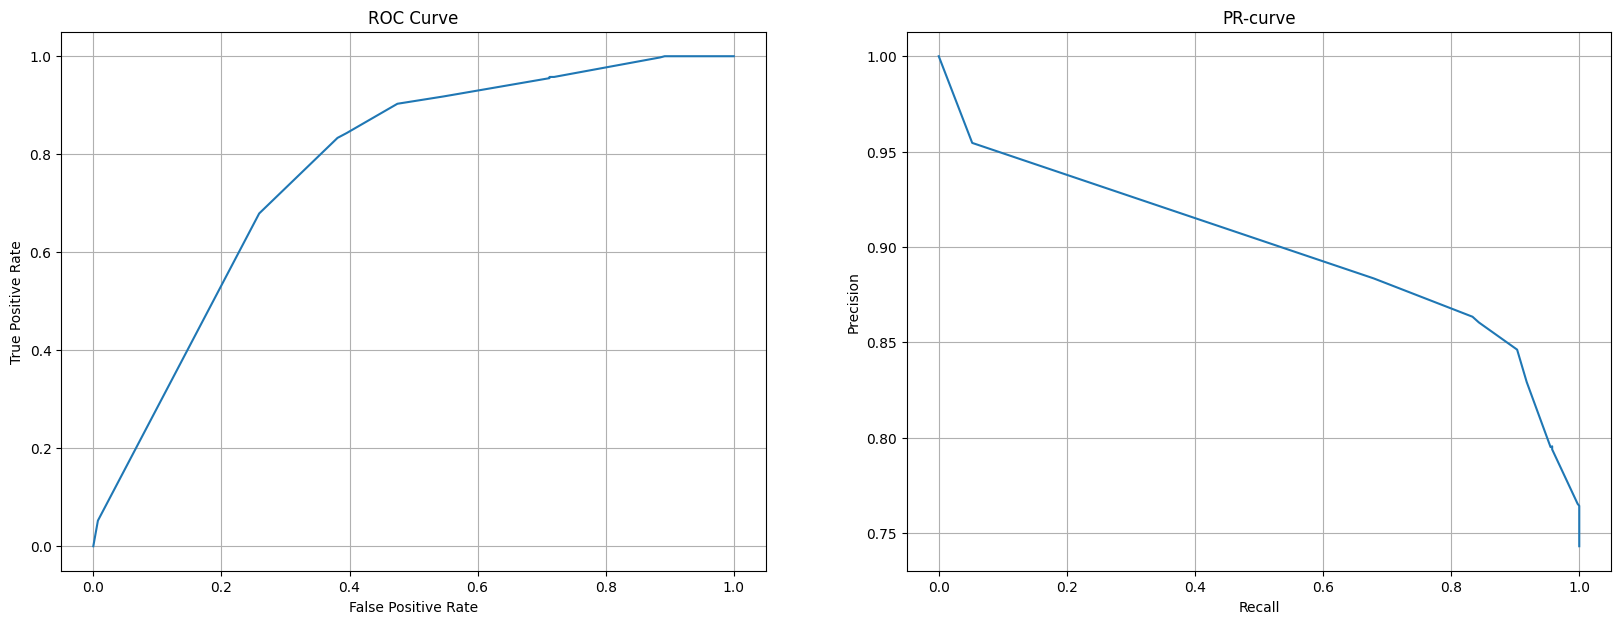

In [43]:
roc = roc_curve(y_trainq,bst_q.predict_proba(X_trainq)[:,1])
pr  = precision_recall_curve(y_trainq,bst_q.predict_proba(X_trainq)[:,1])

f = plt.figure(figsize=(20,7))
ax = f.add_subplot(121)
ax.plot(roc[0],roc[1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve')
ax.grid(which='both')
ax = f.add_subplot(122)
ax.plot(pr[1],pr[0])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_title('PR-curve')
ax.grid(which='both')
plt.show()

In [44]:
#pip install pydeseq2

In [45]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data